In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [228]:
day = 1
df = pd.read_csv(f'data/round-2/prices_round_2_day_{day}.csv', sep = ';')
# df.set_index('timestamp', inplace = True)

In [230]:
# SOLVE SUPPLY DEMAND

P = S = D = df['ORCHIDS'].to_numpy()
T = df['TRANSPORT_FEES'].to_numpy()
E = df['EXPORT_TARIFF'].to_numpy()
I = df['IMPORT_TARIFF'].to_numpy()


TE = T + E
TI = T + I

y = TI * S + TE * D
sunlight_factor = TI * (df['SUNLIGHT'] < 1458).astype('int').cumsum() # TI * ((1458 - df['SUNLIGHT']).clip(lower = 0)).to_numpy()
humidity_factor = TI * ((60 - df['HUMIDITY']).clip(lower = 0) + (df['HUMIDITY'] - 80).clip(lower = 0)).to_numpy()
supply_perfect = TI * np.ones_like(sunlight_factor)
constant_demand = TE * np.ones_like(sunlight_factor)

A = np.stack((supply_perfect, sunlight_factor, humidity_factor, constant_demand)).T
m = np.linalg.lstsq(A, y, rcond = None)
m

(array([ 1.07623565e+03, -1.13686838e-13, -7.15045818e+00,  1.06118249e+03]),
 array([], dtype=float64),
 3,
 array([2.39980131e+03, 9.46328928e+02, 5.74478680e+01, 3.56328602e-13]))

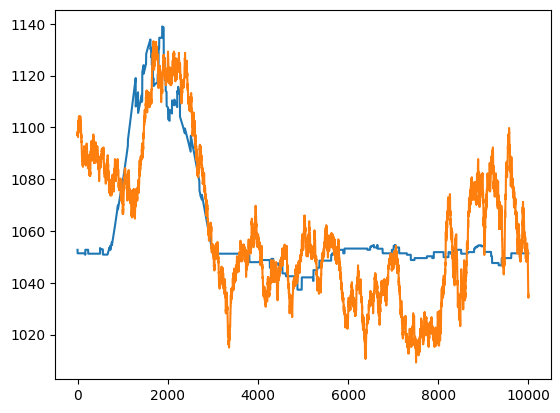

In [231]:
def get_price(reg, df):
    supply_perfect, sunlight_coef, humidity_coef, constant_demand = reg
    s = supply_perfect + sunlight_coef * (df['SUNLIGHT'] < 1458).astype('int') + humidity_coef * (max(0, 60 - df['HUMIDITY']) + max(0, df['HUMIDITY'] - 80)) # max(0, 1458 - df['SUNLIGHT'])
    ti = df['TRANSPORT_FEES'] + df['IMPORT_TARIFF']
    te = df['TRANSPORT_FEES'] + df['EXPORT_TARIFF']
    return (ti * s + te * constant_demand) / (ti + te)

preds = []
for i, row in df.iterrows():
    preds.append(get_price(m[0], row))

preds = np.array(preds)
mkt_price = df['ORCHIDS'].to_numpy()

plt.plot(preds)
plt.plot(mkt_price)

In [232]:
m[0]

array([ 1.07623565e+03, -1.13686838e-13, -7.15045818e+00,  1.06118249e+03])

(0.12158227123085255, 20.647351013466402)

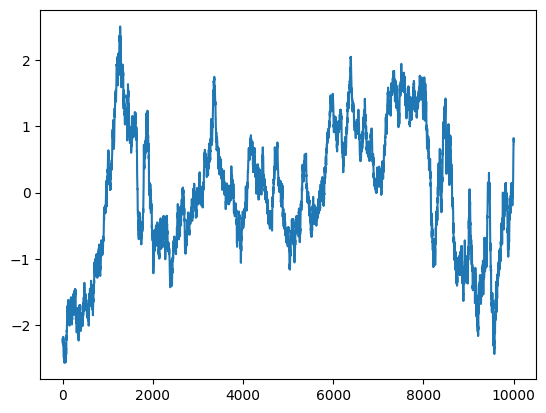

In [235]:
# BET SIZING
dp = preds - mkt_price
plt.plot((dp - dp.mean()) / dp.std())
dp.mean(), dp.std()